# Pick sample and visualize

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
from IPython.display import display
from ipyfilechooser import FileChooser
import os
from data_utils.helpers import visualize_pointcloud, visualize_pointcloud_np
from data_utils.ModelNetDataLoader import pc_normalize

In [3]:
# Create and display a FileChooser widget
fc = FileChooser('/home/hoang/Dataset/')
# Set a file filter patern
fc.filter_pattern = '*.txt'
display(fc)

# Print the selected filename
print(fc.selected_filename)

FileChooser(path='/home/hoang/Dataset', filename='', title='', show_hidden=False, select_desc='Select', change…

None


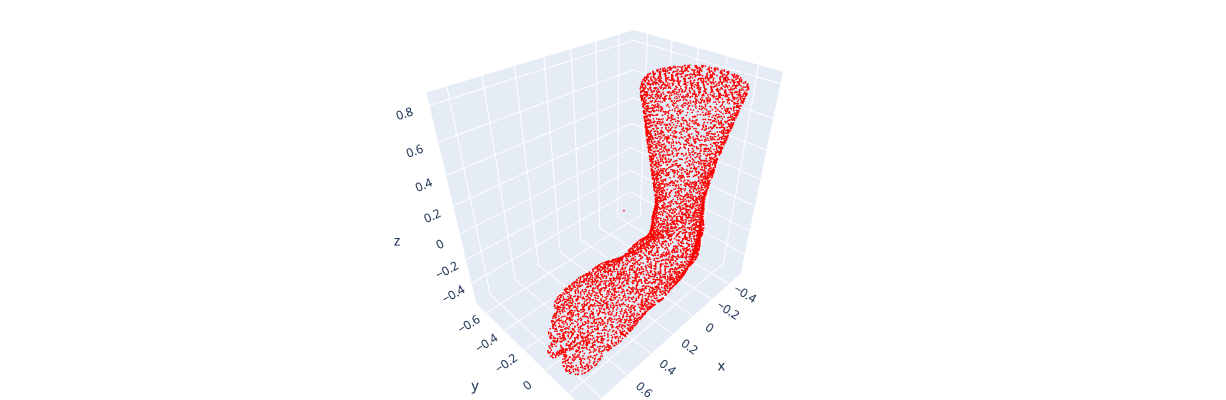

In [30]:
sample_points_path = os.path.join(fc.selected_path, fc.selected_filename)
visualize_pointcloud(sample_points_path, stride=3, flip_axis=-1, postprocess_fn=pc_normalize)

# Run model prediction

This model is trained with these hyperparams:

```
batch_size=32
num_category=42
epoch=200
num_point=6000
optimizer='Adam'
learning_rate=0.001
decay_rate=0.0001
```

Model training results:
Achieves 93.69% Test Accuracy


![](log/classification/pointnet2_cls_ssg_normal_42c/trainresults.png)

In [31]:
# Checkpoints

MODEL_NAME = 'pointnet2_cls_ssg'

# CKPT_PATH = 'log/classification/pointnet2_cls_ssg_normal_42c/checkpoints/best_model.pth' # trained with non-flipped right foots data
# CKPT_PATH = 'log/classification/pointnet2_cls_ssg_normal_42c_all_left/checkpoints/best_model.pth' # trained with flipped right foots data
# USE_NORMALS = True

CKPT_PATH = 'log/classification/pointnet2_cls_ssg_normal_42c_all_left_no_normals/checkpoints/best_model.pth' # trained with flipped right foots data
USE_NORMALS = False


NUM_CLASS = 42
DEVICE='cuda'

In [32]:
import importlib
import sys
import torch
from torchsummary import summary

# import model class
sys.path.append(os.path.join('models'))
checkpoint = torch.load(CKPT_PATH)

# get model by number of classes (categories)
model = importlib.import_module(MODEL_NAME)
classifier = model.get_model(NUM_CLASS, normal_channel=USE_NORMALS)

# load pretrained weights
classifier.load_state_dict(checkpoint['model_state_dict'])
classifier = classifier.eval()

# use summary to view model structure
# summary(classifier, (6, 5000), col_names=['input_size', 'output_size', 'num_params', 'kernel_size']) # (xyzn, num_points)
# None

classifier.to(DEVICE)
None

In [33]:
with open('data/modelnet40_withFootLast_AllLeft/modelnet40_shape_names.txt', 'r') as file:
# with open('data/modelnet40_withFootLast/modelnet40_shape_names.txt', 'r') as file:
    CLASSES = file.read().split()

print("# Classes:", len(CLASSES))
print(', '.join(CLASSES))

# Classes: 42
piano, bottle, bench, wardrobe, cup, night_stand, keyboard, curtain, lamp, tent, stairs, bookshelf, sofa, tv_stand, dresser, flower_pot, range_hood, monitor, toilet, laptop, vase, cone, door, radio, bathtub, desk, mantel, guitar, plant, car, airplane, person, table, foot, glass_box, sink, stool, chair, bed, last, xbox, bowl


In [34]:
import torch
import numpy as np
from data_utils.ModelNetDataLoader import pc_normalize

# read sample point cloud data into numpy array for prediction
points = np.loadtxt(sample_points_path, delimiter=',')
points[:, 0:3] = pc_normalize(points[:, 0:3]) # Normalize

if not USE_NORMALS:
    points = points[:, 0:3]

# Prediction
with torch.no_grad():
    inputs = torch.tensor(points, dtype=torch.float)[None,].transpose(1,2).to(DEVICE) # Put on tensor
    logits, _, crit_idxs = classifier(inputs, return_idxs=True) # Get logits
    pred_idx = logits.data.max(1)[1].item()
    pred = CLASSES[pred_idx]
    
print("Model prediction:", pred.upper())

Model prediction: FOOT


Even when the model was only tranined with left-looking foots and lasts, it still can predict true lables with right-looking foots and lasts.
One possible hint is in the paper about the lost regularization term which makes transformations close to orthogonal. 
The flip transformation from right foot / last to be left-looking is an orthogonal transformation, which could be learnt by PointNet++. That's why this model could predict wrong labels regarless of any orthonal transformation applied to input data.

In [35]:
import torch
TOPK = 3
probs, idxs = torch.softmax(logits, dim=1).cpu().squeeze().sort(descending=True)

for idx, prb in zip(idxs[:TOPK], probs[:TOPK]):
    print(f"{CLASSES[idx]}: {prb:.2%}")

foot: 92.69%
last: 6.97%
desk: 0.11%


In [36]:
crit_idxs = crit_points = points[crit_idxs.cpu().numpy().squeeze(-1)]

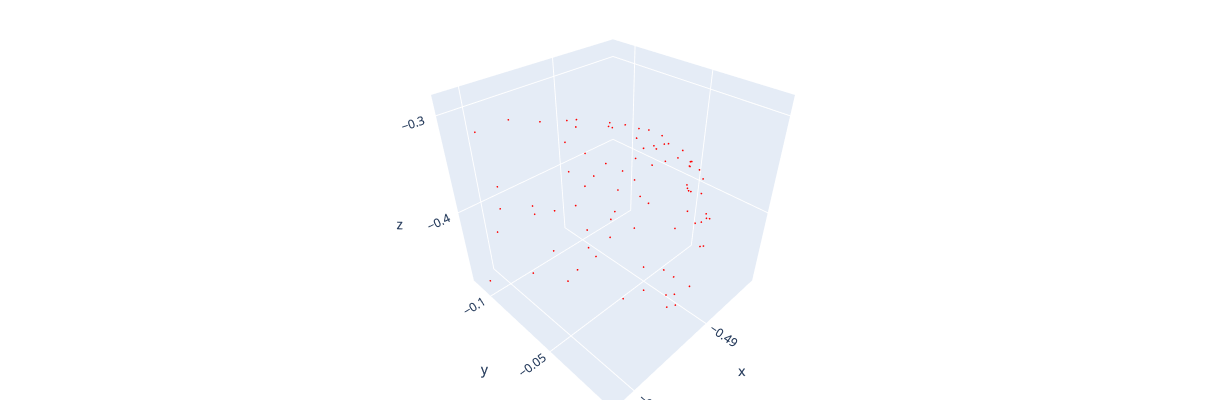

In [38]:
visualize_pointcloud_np(crit_points.squeeze())